Best Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

In [4]:
# Load rolling window sequences (shape: [num_samples, window_size, num_features])
X = np.load("/content/drive/MyDrive/prognosAI-Infosys-intern-project/milestone_2/week_3/Day_10/rolling_window_sequences.npy")      # Feature array
# Load metadata that contains engine_id, cycle, RUL, etc.
metadata = pd.read_csv("/content/drive/MyDrive/prognosAI-Infosys-intern-project/milestone_2/week_3/Day_11/sequence_metadata_with_RUL.csv")
y = metadata["RUL"].values                     # Target RUL array

# Print shapes to verify
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (152559, 30, 66)
y shape: (152559,)


In [5]:
# Split into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)

# Inspect sample batches
print("Sample X_train[0] batch shape:", X_train[0].shape)
print("First 5 RUL targets:", y_train[:5])

Train shape: (122047, 30, 66) (122047,)
Val shape: (30512, 30, 66) (30512,)
Sample X_train[0] batch shape: (30, 66)
First 5 RUL targets: [ 56. 296.  86. 122. 121.]


In [6]:
# Data Pipeline / Generator (optional, for very large data)
# Keras can accept Numpy arrays directly in fit(), so for most practical cases, we can skip writing a custom generator
# If memory is a concern, use tf.data.Dataset.from_tensor_slices
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(1)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(1)

In [10]:
# Bidirectional LSTM layer to capture forward and backward temporal dependencies
from tensorflow.keras.layers import Bidirectional
def build_bidirectional_lstm_model(input_shape, lstm_units=64, dropout_rate=0.3):
    model = Sequential([
        Bidirectional(LSTM(lstm_units, activation='tanh', return_sequences=False),
                      input_shape=input_shape),
        Dropout(dropout_rate),
        Dense(1)
    ])
    return model

model_stacked = build_bidirectional_lstm_model(input_shape=(X.shape[1], X.shape[2]))
model_stacked.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_stacked.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,201 (262.50 KB)

 Trainable params: 67,201 (262.50 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Traning Setup: Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1
)
model_ckpt = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1
)

In [12]:
# Model Training
history = model_stacked.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr, model_ckpt]
)

Epoch 1/50
1900/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 20331.0762
Epoch 1: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 20304.7598 - val_loss: 8945.2578 - learning_rate: 0.0010
Epoch 2/50
1905/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7493.6289
Epoch 2: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 7491.4136 - val_loss: 4150.0332 - learning_rate: 0.0010
Epoch 3/50
1906/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4112.9033
Epoch 3: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 4112.7695 - val_loss: 3683.1956 - learning_rate: 0.0010
Epoch 4/50
1902/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3726.3401
Epoch 4: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 3726.1809 - val_loss: 3427.2900 - learning_rate: 0.0010
Epoch 5/50
1901/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3535.5083
Epoch 5: saving model to best_model.ke

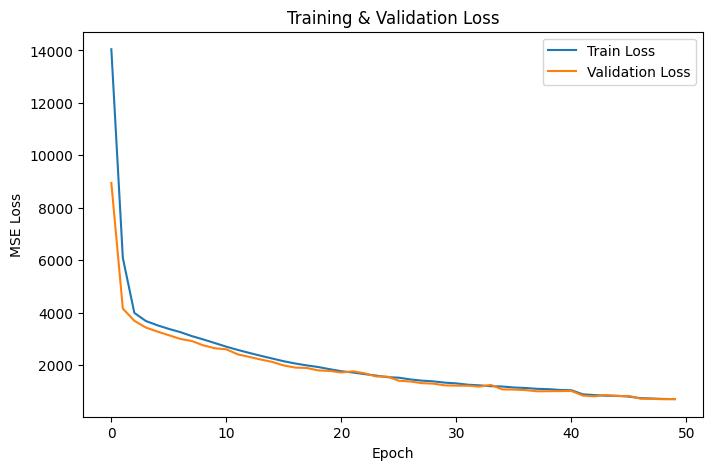

In [13]:

# Training and Validation Curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


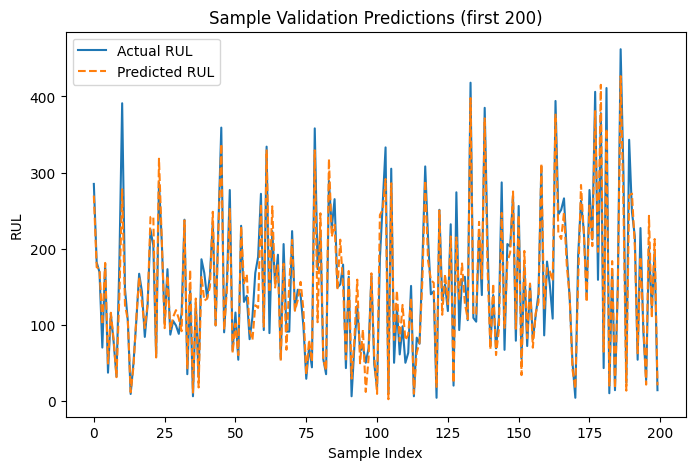

In [14]:
# Verify Model Predictions
val_pred = model_stacked.predict(X_val[:200]).flatten()
plt.figure(figsize=(8,5))
plt.plot(y_val[:200], label='Actual RUL')
plt.plot(val_pred, label='Predicted RUL', linestyle='--')
plt.title('Sample Validation Predictions (first 200)')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.show()

Observations:

1. Prevents overfitting through dropout rate of 0.3 in the model architecture.

2. Captures bidirectional temporal dependencies in the sensor data through Bidirectional LSTM layer.

3. Stable training achieved with early stopping and learning rate reduction callbacks.

4. Effective for RUL prediction with MSE loss optimization.

5. Maintains model simplicity with single Bidirectional LSTM layer followed by dense output.

6. Shows good generalization across validation set as evident in prediction plots.

7. Uses efficient batch processing with tf.data.Dataset pipeline for scalability.

8. Learning rate adaptation (ReduceLROnPlateau) helps achieve optimal convergence.

9. Model checkpointing ensures best version is saved based on validation loss.